In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(rc={'figure.figsize':(14,9)})

## Lade in Spark-Scala aufbereitete Tabelle
https://a100.sbb.ch:8974/notebooks/users/u230261/STA1911/statAnalysis.snb.ipynb?read_only=1

In [2]:
df = pd.read_csv (r'C:\devsbb\lab_dlfw.stats_sta1911_v2.csv',
                  delimiter=";",
                  dtype={'profil_typ': object}, # Sonsts wirds als Exponential-Zahl interpretiert (60E1 = 600.0)
                  usecols=["channel","start_mm","slope_mm_yr","TgGewicht","curve","lastklasse","profil_typ","schw_art","radiusklasse","stat_test_p_min","n_measurements","time_span_yrs"])
    #.dropna(inplace=False)

In [3]:
len(df.index)

2049687

In [4]:
## initiales Filtern : nur Prognose-Äste mit >= 4 samples über min 6 Monate Zeitspanne und bestandenen stat. Tests
df = df[(df.n_measurements >= 4) & (df.time_span_yrs > 0.5) & (df.stat_test_p_min > 0.05/3.0) & (df.channel == "lonled1_ex_std200m")] # Division durch 3 : Bonferroni-Korrektur

In [5]:
len(df.index) #Die Hälfte aller Punkte fliegt hier also weg....

532331

### Playground Feature-Analysis

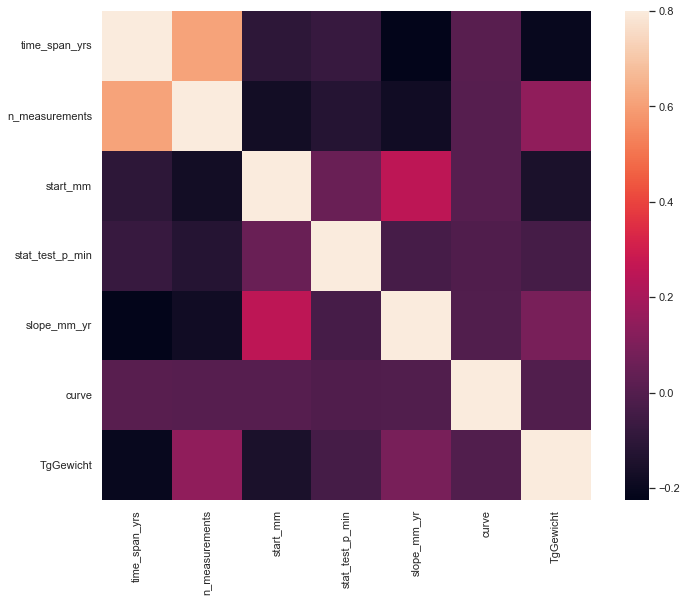

In [6]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Feature-Importance

In [7]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [8]:
x = df[['curve','TgGewicht','schw_art','profil_typ']] ## Auswahl der zu prüfenden Features
y = df['slope_mm_yr']

In [9]:
## One-Hot encoder für Schwellen-Art
discarded = pd.get_dummies(x['schw_art'],prefix = 'schw_art')
x = pd.concat([x.drop("schw_art",1), discarded], axis = 1)

In [10]:
## One-Hot encoder für Profil-Typ
discarded = pd.get_dummies(x['profil_typ'],prefix = 'profil_typ')
x = pd.concat([x.drop("profil_typ",1), discarded], axis = 1)

Feature ranking:
1. feature 1 (0.606639)
2. feature 0 (0.348424)
3. feature 7 (0.009739)
4. feature 3 (0.009015)
5. feature 4 (0.008124)
6. feature 6 (0.006666)
7. feature 2 (0.006662)
8. feature 5 (0.004731)


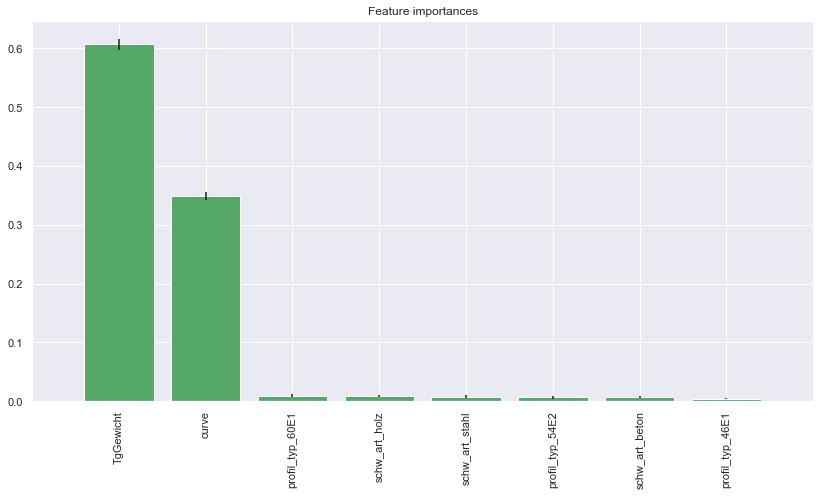

In [11]:
rfr = RandomForestRegressor()
f_rfr = rfr.fit(x, y)
importances = f_rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 7))
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.show()

Library von WillKoehrsen

In [12]:
from feature_selector import FeatureSelector

import pandas as pd

In [13]:
train = df[['slope_mm_yr','curve','TgGewicht','schw_art','profil_typ']]
train_labels = train['slope_mm_yr']
train.head()

,slope_mm_yr,curve,TgGewicht,schw_art,profil_typ
7,0.019903,-0.00099,43919.0,holz,54E2
9,0.038722,-0.00099,43919.0,holz,54E2
11,0.006086,-0.00099,47414.0,holz,54E2
17,0.038573,-0.00099,48232.0,holz,54E2
19,0.011878,-0.00099,41039.0,holz,54E2


In [14]:
train = train.drop(columns = ['slope_mm_yr'])

In [15]:
fs = FeatureSelector(data = train, labels = train_labels)

In [16]:
fs.identify_single_unique()

0 features with a single unique value.



In [17]:
single_unique = fs.ops['single_unique']
single_unique

[]

In [18]:
fs.unique_stats

,nunique
schw_art,3
profil_typ,3
TgGewicht,8714
curve,69317


In [19]:
fs.identify_collinear(correlation_threshold=0.98)

0 features with a correlation magnitude greater than 0.98.



In [ ]:
fs.identify_zero_importance(task = 'regression', eval_metric = 'l2',
                            n_iterations = 10, early_stopping = False)

Training Gradient Boosting Model



In [ ]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

In [ ]:
fs.data_all.head(10)

In [ ]:
zero_importance_features = fs.ops['zero_importance']
zero_importance_features[10:15]

In [ ]:
fs.plot_feature_importances(plot_n=8)